## importing the necessities

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor

from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_log_error

## importing data-set (on- or offline), train-/test-split

In [ ]:
url = "https://drive.google.com/file/d/1qHmfy0mtlZ0UPw9rFGsnSD4E0VfUv1HO/view?usp=sharing"
data = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
housing = pd.read_csv(data)
y = housing.pop("SalePrice")
X = housing.drop("Id", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=815)

In [2]:
data = r"C:\Users\danie\Desktop\WBS.DataScience_Bootcamp\Week_10_supervised_ML_regression\challenge\train.csv"
housing = pd.read_csv(data)
y = housing.pop("SalePrice")
X = housing.drop("Id", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=815)

## setting up the preprocessing steps

In [6]:
num_feats = list(X_train.select_dtypes(exclude=["object"]))
ord_feats = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "FireplaceQu", "BsmtFinType2",
             "HeatingQC", "Fence", "PoolQC", "PavedDrive", "GarageCond", "GarageQual", "GarageFinish"]
cat_feats = list(set(list(X_train.select_dtypes(include=["object"])))-set(ord_feats))

num_pipe = make_pipeline(
    SimpleImputer(
    strategy="mean")
    )

ord_pipe = make_pipeline(
        SimpleImputer(
    strategy="constant", fill_value="NA"),
        OrdinalEncoder(
    categories=[["Po", "Fa", "TA", "Gd", "Ex"], ["Po", "Fa", "TA", "Gd", "Ex"], ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
                ["NA", "Po", "Fa", "TA", "Gd", "Ex"], ["NA", "No", "Mn", "Av", "Gd"], ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
                ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
                ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], ["Po", "Fa", "TA", "Gd", "Ex"], ["NA", "MnWw", "GdWo", "MnPrv", "GdPrv"],
                ["NA", "Fa", "TA", "Gd", "Ex"], ["N", "P", "Y"], ["NA", "Po", "Fa", "TA", "Gd", "Ex"], ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
                ["NA", "Unf", "RFn", "Fin"]
                ])
    )

cat_pipe = make_pipeline(
        SimpleImputer(
    strategy="constant", fill_value="N_A"),
        OneHotEncoder(
    sparse_output=False, handle_unknown="ignore")
    )

preprocessor = ColumnTransformer(
    transformers=[
    ("num_pipe", num_pipe, num_feats),
    ("ord_pipe", ord_pipe, ord_feats),
    ("cat_pipe", cat_pipe, cat_feats)
    ]
)

## defining scalers and models

In [4]:
minmax = MinMaxScaler()
maxabs = MaxAbsScaler()
scalers = [minmax, maxabs]

df = RandomForestRegressor()
gbr = GradientBoostingRegressor()
sgd = SGDRegressor()
vr_1 = VotingRegressor(estimators=[("df", df), ("gbr", gbr)])
vr_2 = VotingRegressor(estimators=[("df", df), ("sgd", sgd)])
vr_3 = VotingRegressor(estimators=[("gbr", gbr), ("sgd", sgd)])
vr_4 = VotingRegressor(estimators=[("gbr", gbr), ("sgd", sgd), ("df", df)])
algorithms = [df, gbr, sgd, vr_1, vr_2, vr_3, vr_4]



## performance check

In [7]:
perf = pd.DataFrame()
for scaler in scalers:
    for algorithm in algorithms:
        pipe = make_pipeline(preprocessor, scaler, algorithm).set_output(transform="pandas")
        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_test)
        perf.loc[f"{algorithm}", f"{scaler}"] = mean_squared_log_error(y_test, pred, squared=False)

In [8]:
perf

,MinMaxScaler(),MaxAbsScaler()
RandomForestRegressor(),0.155971,0.155050
GradientBoostingRegressor(),0.141559,0.142856
SGDRegressor(),0.150365,0.148684
"VotingRegressor(estimators=[('df', RandomForestRegressor()),\n ('gbr', GradientBoostingRegressor())])",0.143960,0.142836
"VotingRegressor(estimators=[('df', RandomForestRegressor()),\n ('sgd', SGDRegressor())])",0.131617,0.133590
"VotingRegressor(estimators=[('gbr', GradientBoostingRegressor()),\n ('sgd', SGDRegressor())])",0.129865,0.128084
"VotingRegressor(estimators=[('gbr', GradientBoostingRegressor()),\n ('sgd', SGDRegressor()),\n ('df', RandomForestRegressor())])",0.130893,0.132765


## visualisation vr(gbr, sgd) / vr_3

In [16]:
pipe_vr3 = make_pipeline(preprocessor, scaler, vr_3).set_output(transform="pandas")
pipe_vr3.fit(X_train, y_train)
pred = pipe_vr3.predict(X_test)
plot = X_test.copy()
plot["error"] = y_test - pred 

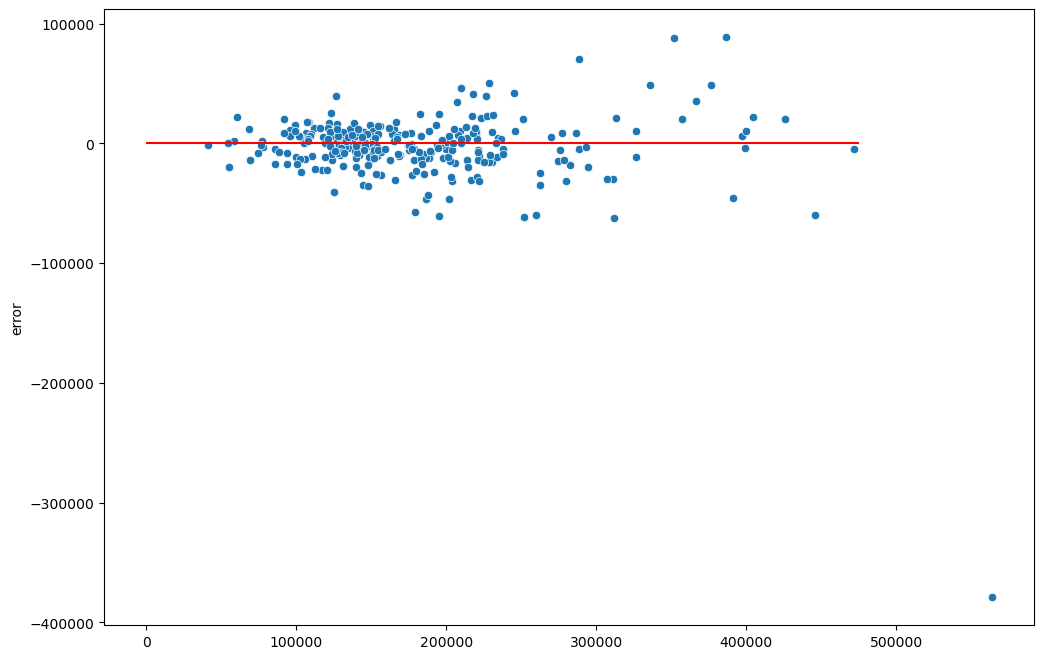

In [17]:
plt.subplots(figsize=(12, 8))
sns.scatterplot(data=plot, x=pred, y=plot.error)
plt.hlines(y=0, xmin=0, xmax=max(y_test), color='red')
plt.show()

## focus on vr(gbr, sgd), running CV for possible improvements

In [38]:
pipe_sgd = make_pipeline(preprocessor, scaler, sgd).set_output(transform="pandas")

In [63]:
import sklearn.metrics

In [64]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [65]:
params = {
    "columntransformer__num_pipe__simpleimputer__strategy": ["mean", "median"],

    "sgdregressor__loss": ["squared_error", "huber"]
#    "pipe_vr3__votingregressor__min_samples_leaf": range(1,35,5),
#    "pipe_vr3__votingregressor__min_samples_split": range(1,25,5)
}

rnd_sgd = RandomizedSearchCV(pipe_sgd, params, n_iter=50, scoring="neg_mean_squared_log_error", verbose=1)

In [66]:
rnd_sgd.fit(X_train, y_train)

c:\Users\danie\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\danie\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1549: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\danie\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1549: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\danie\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1549: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\danie\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1549: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\danie\anaconda3\lib\site-packages\sklearn\linea

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('num_pipe',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer())]),
                                                                               ['MSSubClass',
                                                                                'LotFrontage',
                                                                                'LotArea',
                                                                                'OverallQual',
                                                                                'OverallCond',
                                                                                'YearBuilt',
                                                                                'YearRemodAdd',
                                                                                'MasVnrArea',
                                                                                'BsmtFinSF1',
                                                                                'BsmtFinSF2',
                                                                                'BsmtUnfSF',
                                                                                'TotalBsmtSF',
                                                                                '1stFlrSF',
                                                                                '2ndFlrSF',
                                                                                'LowQual...
                                                                                'Foundation',
                                                                                'KitchenQual',
                                                                                'HouseStyle',
                                                                                'RoofStyle',
                                                                                'LandSlope',
                                                                                'RoofMatl',
                                                                                'Exterior1st'])])),
                                             ('maxabsscaler', MaxAbsScaler()),
                                             ('sgdregressor', SGDRegressor())]),
                   n_iter=50,
                   param_distributions={'columntransformer__num_pipe__simpleimputer__strategy': ['mean',
                                                                                                 'median'],
                                        'sgdregressor__loss': ['squared_error',
                                                               'huber']},
                   scoring='neg_mean_squared_log_error', verbose=1)

In [67]:
rnd_sgd.best_params_

{'sgdregressor__loss': 'squared_error',
 'columntransformer__num_pipe__simpleimputer__strategy': 'median'}

In [68]:
rnd_sgd.best_score_

-0.023266043829081887

In [69]:
pipe_gbr = make_pipeline(preprocessor, scaler, gbr).set_output(transform="pandas")


In [70]:
params = {
    "columntransformer__num_pipe__simpleimputer__strategy": ["mean", "median"],
    "gradientboostingregressor__max_depth": range(2,9,2),
    "gradientboostingregressor__min_samples_leaf": range(1,35,5),
    "gradientboostingregressor__min_samples_split": range(1,35,5)
}
rnd_gbr = RandomizedSearchCV(pipe_gbr, params, n_iter=50, scoring="neg_mean_squared_log_error", verbose=1)

In [71]:
rnd_gbr.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('num_pipe',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer())]),
                                                                               ['MSSubClass',
                                                                                'LotFrontage',
                                                                                'LotArea',
                                                                                'OverallQual',
                                                                                'OverallCond',
                                                                                'YearBuilt',
                                                                                'YearRemodAdd',
                                                                                'MasVnrArea',
                                                                                'BsmtFinSF1',
                                                                                'BsmtFinSF2',
                                                                                'BsmtUnfSF',
                                                                                'TotalBsmtSF',
                                                                                '1stFlrSF',
                                                                                '2ndFlrSF',
                                                                                'LowQual...
                                              GradientBoostingRegressor())]),
                   n_iter=50,
                   param_distributions={'columntransformer__num_pipe__simpleimputer__strategy': ['mean',
                                                                                                 'median'],
                                        'gradientboostingregressor__max_depth': range(2, 9, 2),
                                        'gradientboostingregressor__min_samples_leaf': range(1, 35, 5),
                                        'gradientboostingregressor__min_samples_split': range(1, 35, 5)},
                   scoring='neg_mean_squared_log_error', verbose=1)

In [72]:
rnd_gbr.best_score_

-0.017595492825399146

In [73]:
rnd_gbr.best_params_

{'gradientboostingregressor__min_samples_split': 16,
 'gradientboostingregressor__min_samples_leaf': 1,
 'gradientboostingregressor__max_depth': 4,
 'columntransformer__num_pipe__simpleimputer__strategy': 'median'}

In [74]:
sgd_pred = sgd

gbr_pred = GradientBoostingRegressor(min_samples_split=16, min_samples_leaf=1, max_depth=4)

vr_pred = VotingRegressor([("sgd", sgd_pred), ("gbr", gbr_pred)])

In [75]:
num_feats = list(X_train.select_dtypes(exclude=["object"]))
ord_feats = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "FireplaceQu", "BsmtFinType2",
             "HeatingQC", "Fence", "PoolQC", "PavedDrive", "GarageCond", "GarageQual", "GarageFinish"]
cat_feats = list(set(list(X_train.select_dtypes(include=["object"])))-set(ord_feats))

num_pipe = make_pipeline(
    SimpleImputer(
    strategy="median")
    )

ord_pipe = make_pipeline(
        SimpleImputer(
    strategy="constant", fill_value="NA"),
        OrdinalEncoder(
    categories=[["Po", "Fa", "TA", "Gd", "Ex"], ["Po", "Fa", "TA", "Gd", "Ex"], ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
                ["NA", "Po", "Fa", "TA", "Gd", "Ex"], ["NA", "No", "Mn", "Av", "Gd"], ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
                ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
                ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], ["Po", "Fa", "TA", "Gd", "Ex"], ["NA", "MnWw", "GdWo", "MnPrv", "GdPrv"],
                ["NA", "Fa", "TA", "Gd", "Ex"], ["N", "P", "Y"], ["NA", "Po", "Fa", "TA", "Gd", "Ex"], ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
                ["NA", "Unf", "RFn", "Fin"]
                ])
    )

cat_pipe = make_pipeline(
        SimpleImputer(
    strategy="constant", fill_value="N_A"),
        OneHotEncoder(
    sparse_output=False, handle_unknown="ignore")
    )

preprocessor = ColumnTransformer(
    transformers=[
    ("num_pipe", num_pipe, num_feats),
    ("ord_pipe", ord_pipe, ord_feats),
    ("cat_pipe", cat_pipe, cat_feats)
    ]
)

In [80]:
alg_pred = [sgd_pred, gbr_pred, vr_pred]
pred_df = pd.DataFrame()
for alg in alg_pred:
    for scaler in scalers:
        pipe_pred = make_pipeline(preprocessor, scaler, alg).set_output(transform="pandas")
        pipe_pred.fit(X_train, y_train)
        pred = pipe_pred.predict(X_test)
        pred_df.loc[f"{alg}", f"{scaler}"] = mean_squared_log_error(y_test, pred, squared=False)

In [81]:
pred_df

,MinMaxScaler(),MaxAbsScaler()
SGDRegressor(),0.150480,0.148893
"GradientBoostingRegressor(max_depth=4, min_samples_split=16)",0.137545,0.137708
"VotingRegressor(estimators=[('sgd', SGDRegressor()),\n ('gbr',\n GradientBoostingRegressor(max_depth=4,\n min_samples_split=16))])",0.127769,0.127565


In [82]:
pipe_gbr = make_pipeline(preprocessor, scaler, gbr).set_output(transform="pandas")
params = {
    #"columntransformer__num_pipe__simpleimputer__strategy": ["mean", "median"],
    "gradientboostingregressor__max_depth": range(2,5),
    "gradientboostingregressor__min_samples_split": range(9,22,3)
}
grid_gbr = GridSearchCV(pipe_gbr, params, scoring="neg_mean_squared_log_error", verbose=1)

In [83]:
grid_gbr.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['MSSubClass',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'MasVnrArea',
                                                                          'BsmtFinSF1',
                                                                          'BsmtFinSF2',
                                                                          'BsmtUnfSF',
                                                                          'TotalBsmtSF',
                                                                          '1stFlrSF',
                                                                          '2ndFlrS...
                                                                          'Foundation',
                                                                          'KitchenQual',
                                                                          'HouseStyle',
                                                                          'RoofStyle',
                                                                          'LandSlope',
                                                                          'RoofMatl',
                                                                          'Exterior1st'])])),
                                       ('maxabsscaler', MaxAbsScaler()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor())]),
             param_grid={'gradientboostingregressor__max_depth': range(2, 5),
                         'gradientboostingregressor__min_samples_split': range(9, 22, 3)},
             scoring='neg_mean_squared_log_error', verbose=1)

In [84]:
grid_gbr.best_score_

-0.01747387524444082

In [85]:
grid_gbr.best_params_

{'gradientboostingregressor__max_depth': 4,
 'gradientboostingregressor__min_samples_split': 15}

In [86]:
sgd_pred = sgd

gbr_pred = GradientBoostingRegressor(min_samples_split=16, min_samples_leaf=1, max_depth=4)
gbr_pred_2 = GradientBoostingRegressor(min_samples_split=15, min_samples_leaf=1, max_depth=4)

vr_pred = VotingRegressor([("sgd", sgd_pred), ("gbr", gbr_pred)])
vr_pred_2 = VotingRegressor([("sgd", sgd_pred), ("gbr", gbr_pred_2)])

In [90]:
alg_pred_2 = [sgd_pred, gbr, gbr_pred, gbr_pred_2, vr_3, vr_pred, vr_pred_2]
pred_df_2 = pd.DataFrame()
for alg in alg_pred_2:
    for scaler in scalers:
        pipe_pred = make_pipeline(preprocessor, scaler, alg).set_output(transform="pandas")
        pipe_pred.fit(X_train, y_train)
        pred = pipe_pred.predict(X_test)
        pred_df_2.loc[f"{alg}", f"{scaler}"] = mean_squared_log_error(y_test, pred, squared=False)

In [91]:
pred_df_2

,MinMaxScaler(),MaxAbsScaler()
SGDRegressor(),0.155678,0.148785
GradientBoostingRegressor(),0.139107,0.140884
"GradientBoostingRegressor(max_depth=4, min_samples_split=16)",0.136370,0.137237
"GradientBoostingRegressor(max_depth=4, min_samples_split=15)",0.138466,0.138064
"VotingRegressor(estimators=[('gbr', GradientBoostingRegressor()),\n ('sgd', SGDRegressor())])",0.129503,0.127715
"VotingRegressor(estimators=[('sgd', SGDRegressor()),\n ('gbr',\n GradientBoostingRegressor(max_depth=4,\n min_samples_split=16))])",0.128638,0.127270
"VotingRegressor(estimators=[('sgd', SGDRegressor()),\n ('gbr',\n GradientBoostingRegressor(max_depth=4,\n min_samples_split=15))])",0.127202,0.128536


## first shot @official test set, untweaked vr3

In [92]:
data = r"C:\Users\danie\Desktop\WBS.DataScience_Bootcamp\Week_10_supervised_ML_regression\challenge\test.csv"
challenge = pd.read_csv(data)

In [93]:
pipe_ch1 = make_pipeline(preprocessor, maxabs, vr_3).set_output(transform="pandas")
pipe_ch1.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLi...
                                                   'SaleType', 'Functional',
                                                   'BldgType', 'MasVnrType',
                                                   'Exterior2nd', 'Heating',
                                                   'Utilities', 'MiscFeature',
                                                   'SaleCondition',
                                                   'Condition1', 'Street',
                                                   'Foundation', 'KitchenQual',
                                                   'HouseStyle', 'RoofStyle',
                                                   'LandSlope', 'RoofMatl',
                                                   'Exterior1st'])])),
                ('maxabsscaler', MaxAbsScaler()),
                ('votingregressor',
                 VotingRegressor(estimators=[('gbr',
                                              GradientBoostingRegressor()),
                                             ('sgd', SGDRegressor())]))])

In [127]:
challenge.head()
Id = challenge.pop("Id")

KeyError: 'Id'

In [128]:
Prediction = pipe_ch1.predict(challenge)

In [129]:
solution_1 = pd.DataFrame(Id)

In [130]:
solution_1["SalePrice"] = Prediction

In [131]:
solution_1.set_index("Id")

,SalePrice
Id,
1461,117273.390020
1462,159673.708372
1463,180839.234480
1464,185394.257358
1465,203267.763146
...,...
2915,81661.297081
2916,78820.272104
2917,162414.307440


In [133]:
solution_1.to_csv("solution_1.csv", index=False)

## untweaked vr_3 scored .13548. having a try with the tweaked gbr in vr

In [ ]:
vr_pred_2 = VotingRegressor([("sgd", sgd_pred), ("gbr", gbr_pred_2)])

In [134]:
pipe_ch2 = make_pipeline(preprocessor, maxabs, vr_pred_2).set_output(transform="pandas")
pipe_ch2.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLi...
                                                   'Exterior2nd', 'Heating',
                                                   'Utilities', 'MiscFeature',
                                                   'SaleCondition',
                                                   'Condition1', 'Street',
                                                   'Foundation', 'KitchenQual',
                                                   'HouseStyle', 'RoofStyle',
                                                   'LandSlope', 'RoofMatl',
                                                   'Exterior1st'])])),
                ('maxabsscaler', MaxAbsScaler()),
                ('votingregressor',
                 VotingRegressor(estimators=[('sgd', SGDRegressor()),
                                             ('gbr',
                                              GradientBoostingRegressor(max_depth=4,
                                                                        min_samples_split=15))]))])

In [135]:
pipe_ch2.predict(challenge)

array([119829.84484874, 161596.58706303, 177814.12593518, ...,
       171062.55763343, 113231.77805347, 223015.28939684])

In [139]:
Prediction_2 = pipe_ch2.predict(challenge)
solution_2 = pd.DataFrame(Id)
solution_2["SalePrice"] = Prediction_2
solution_2.set_index("Id")

,SalePrice
Id,
1461,119829.844849
1462,161596.587063
1463,177814.125935
1464,189159.291512
1465,199345.090884
...,...
2915,82703.435296
2916,79520.180629
2917,171062.557633


In [140]:
solution_2.to_csv("solution_2.csv", index=False)

In [142]:
num_feats = list(X_train.select_dtypes(exclude=["object"]))
full_cat_feats = list(X_train.select_dtypes(include=["object"]))
ord_feats = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "KitchenQual", "FireplaceQu", "MSZoning", "BsmtFinType2",
             "HeatingQC", "Fence", "PoolQC", "PavedDrive", "GarageCond", "GarageQual", "GarageFinish"]
cat_feats = list(set(list(X_train.select_dtypes(include=["object"])))-set(ord_feats))
# directly pipelining for both categorical encodings

num_pipe = make_pipeline(
    SimpleImputer(
    strategy="median")
    )


ord_pipe = make_pipeline(
        SimpleImputer(
    strategy="constant", fill_value="NA"),
        OrdinalEncoder(
    categories=[["Po", "Fa", "TA", "Gd", "Ex"], ["Po", "Fa", "TA", "Gd", "Ex"], ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
                ["NA", "Po", "Fa", "TA", "Gd", "Ex"], ["NA", "No", "Mn", "Av", "Gd"], ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
                ["Po", "Fa", "TA", "Gd", "Ex"], ["NA", "Po", "Fa", "TA", "Gd", "Ex"], ["I", "C (all)", "A", "RH", "RM", "FV", "RL", "RP"],
                ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], ["Po", "Fa", "TA", "Gd", "Ex"], ["NA", "MnWw", "GdWo", "MnPrv", "GdPrv"],
                ["NA", "Fa", "TA", "Gd", "Ex"], ["N", "P", "Y"], ["NA", "Po", "Fa", "TA", "Gd", "Ex"], ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
                ["NA", "Unf", "RFn", "Fin"]
                ])
    )

cat_pipe = make_pipeline(
        SimpleImputer(
    strategy="constant", fill_value="N_A"),
        OneHotEncoder(
    sparse_output=False, handle_unknown="ignore")
    )

preprocessor = ColumnTransformer(
    transformers=[
    ("num_pipe", num_pipe, num_feats),
    ("ord_pipe", ord_pipe, ord_feats),
    ("cat_pipe", cat_pipe, cat_feats)
    ]
)